Let’s get started.

What is a Vision Transformer?
Transformers have been widely used in natural language processing tasks. However, they have recently been applied in computer vision — hence the Vision Transformer name.

Vision Transformers work as follows:

The images are split into fixed-size patches.
The image patches are flattened and linearly embedded.
Add position embeddings to retain positional information.
Pass them to the standard Transformer encoder.

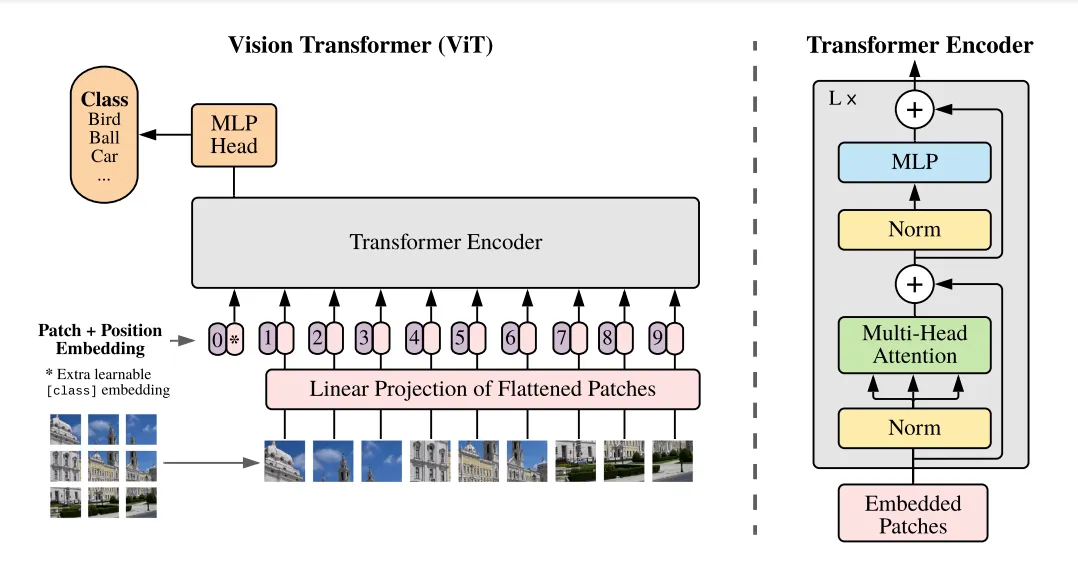

***How does OWL-ViT work?:***


OWL-ViT model is an open-vocabulary object detection model that uses the standard Vision Transformer to perform detection. The Transformer is used for object detection by:

Replacing the final token pooling layer with classification and box head.
Implementing open vocabulary classification by changing the fixed classification layer weights with the class-name embeddings from the text model.
Fine-tuning the pre-trained model with objection detection datasets using a bipartite matching loss.
Fine-tuning text and image models end-to-end.
The OWL-ViT model can be used as a one-shot detection learner. In one-shot learning, a model is trained on one example or very few examples in each category and used to make predictions on unseen samples. For example, when a human being sees one lion, they can easily recognize lions in various settings in the future.

The OWL-ViT model accepts an image and one or more text queries and looks for objects matching the queries.

***OWL-ViT architecture:***


Let’s now look at the architecture of the OWL-ViT model.

The encoder-only OWL-ViT model was developed by:

Contrastive pre-training of an image and text encoder using image-text pairs.
Transferring the pre-trained encoders to open vocabulary. This is done by replacing token pooling with an objection detection and localization head. The object detection and localization head are attached to the image encoder output tokens.
Embedding query strings with the text encoder for open vocabulary detection. The query strings are then used for classification.
Classification is done using the focal sigmoid cross-entropy since images can have multiple labels.

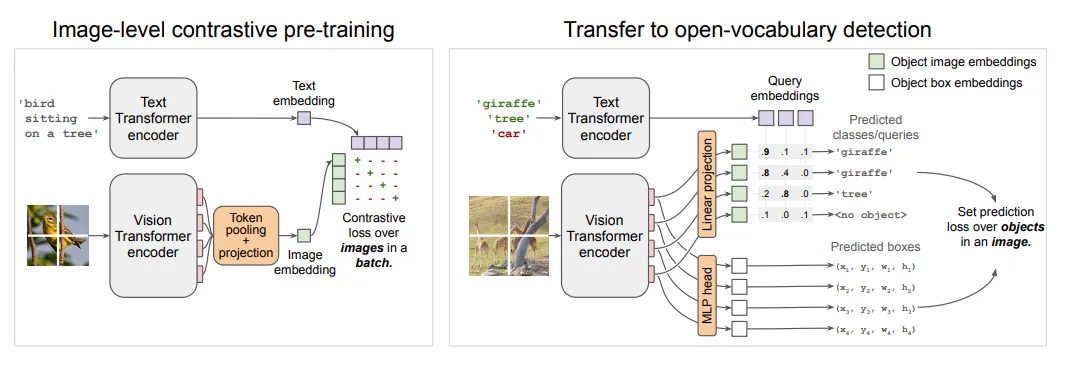

Training is done using the contrastive loss function that encourages corresponding image-text pairs to have similar embeddings and non-corresponding pairs to have distinct embeddings. Contrastive pre-training involves learning the text and image embeddings at the same time. The goal is to learn the text embedding that aligns with the image embedding. A multi-head attention pooling (MAP) is used for aggregating image representations.

Text embeddings are obtained by passing category names to the text encoder. In OWL-ViT, the text embeddings are referred to as queries. The OWL-ViT model predicts a bounding box and the probability that a certain text embedding applies to a particular object. OWL-ViT can also be used to make predictions given queries as image embeddings, making it possible to detect objects that can’t be described. This is enabled by the fact that there is no fusion between the text and image encoders.

***CLIP (Contrastive Language-Image Pretraining) is used as OWL-ViT’s backbone. CLIP works by:***

Training an image and text encoder to predict text and image pairs.
Performing zero-shot classification during inference.
CLIP predicts the text and image pairs by learning a multi-modal embedding space. This is done by training an image encoder and text encoder to maximize the cosine similarity between the correct image and text embedding pairs while reducing the cosine similarity of incorrect pairs using a symmetric loss function.



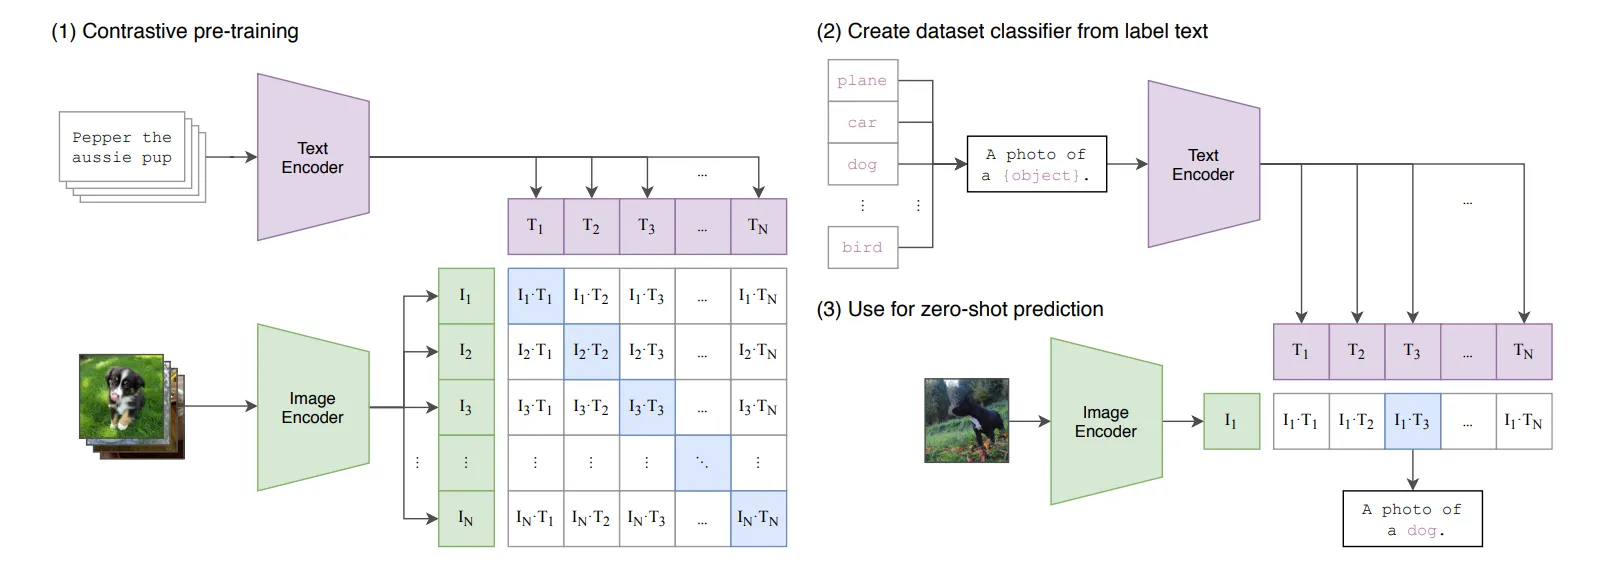

CLIP has some limitations. They include:

CLIP’s zero-shot performance is weak on some tasks such as differentiating car models and flower species.
Gives near random predictions for tasks not seen in the training data.
Generalizes poorly to image distributions that are out-of-distribution.

***In the example below, we:***

Download an image using Pillow.

Process the image and tokenize the text queries using the OwlViTProcessor function. The processor is responsible for resizing, scaling, and normalizing the images. The text queries are tokenized using the CLIP tokenizer.

Pass the inputs to the OwlViTForObjectDetection model to get object predictions. The model's output is the predicted logits, boundary boxes, class, image, and text embeddings.

Obtain and print the predictions for given text queries.

In [7]:
import requests
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection

processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")



In [13]:
url = "https://farm2.staticflickr.com/1449/24800673529_64272a66ec_z_d.jpg"
image = Image.open(requests.get(url, stream=True).raw)
texts = [["a photo of a mushroom", "a photo of a tree"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

score_threshold = 0.1
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    if score >= score_threshold:
        print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

Detected a photo of a mushroom with confidence 0.659 at location [225.94, 89.03, 361.09, 316.85]
Detected a photo of a mushroom with confidence 0.705 at location [133.02, 120.49, 247.33, 322.16]
Detected a photo of a mushroom with confidence 0.313 at location [132.64, 214.99, 194.21, 316.02]


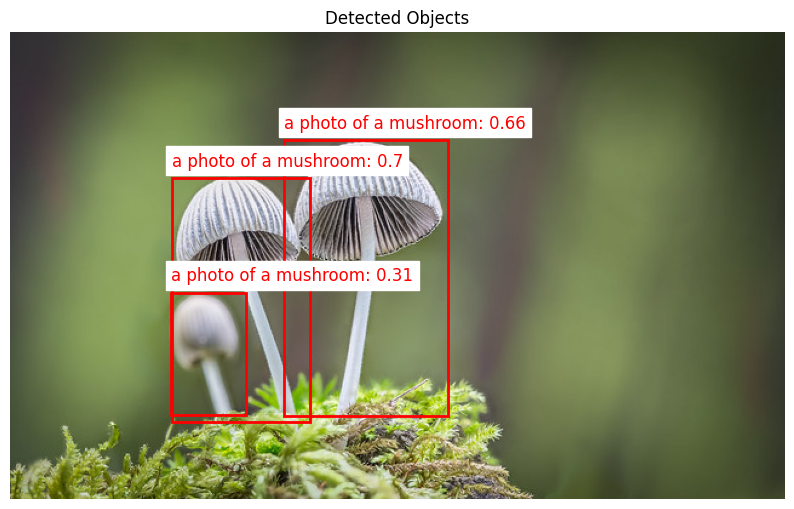

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Display input image
plt.figure(figsize=(10, 10))
plt.imshow(image)
ax = plt.gca()

# Draw bounding boxes
for box, score, label in zip(boxes, scores, labels):
    if score >= score_threshold:
        # Detach the box tensor and convert it to a list
        box = box.detach().numpy().tolist()  # This line is changed
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin - 10, f"{text[label]}: {round(score.item(), 2)}", color='red', fontsize=12, backgroundcolor="white")

plt.axis("off")
plt.title("Detected Objects")
plt.show()

***URL for testing:***

https://www.linkedin.com/pulse/100-free-image-url-testing-guest-posting-sites-sv0xf/